In [1]:
%matplotlib inline

import os
import pickle
import shutil
import sys

import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from azureml.logging import get_azureml_logger

import matplotlib.pyplot as plt
import seaborn as sns

from code.utilities import keras_hlprs, rw_hlprs
from azure.storage.blob import BlockBlobService
from itertools import chain

logger = get_azureml_logger()

Using TensorFlow backend.


## Transform the Predicted Label into its Accompanying Tags

`get_predicted_tags()` will take an encoded label of reals 0 <= n <= 1, enforce a threshold that results a binary classification, and return its original value.

Ex. [0.1, 0.2, 0.0, 0.4, 0.6, 0.3, 0.0, 0.2] => [0, 0, 0, 1, 1, 0, 0, 0] => [primary, partly_cloudy]

In [2]:
def get_predicted_tags(predictions, thresholds, encoder):
        prediction_labels = []
        for prediction in predictions:
            labels = [int(value > thresholds[i]) for i, value in enumerate(prediction)]
            prediction_labels.append(labels)
        tags = [sorted(list(a)) for a in encoder.inverse_transform(np.asarray(prediction_labels))]

        return tags

## Dataframe of Associated Tags

Using the image name (ex. train_1002.jpg) as the index, `create_dataframe()` creates a mapping of the image location with its tags that are sourced from a provided CSV file. The tags are then encoded as a One-Hot array and returned in the column __labels__. 

In [3]:
def create_dataframe(runtime_params, blob_service):
    
    label_df = None
    val_paths = []
    img_path_tups = []

    # gather all image file paths as list of strings
    if runtime_params['sample_flag'] == 'true':
        import glob
        val_paths = glob.glob('sample_data/validation-sample-jpg/*.jpg')
        label_df = pd.DataFrame.from_csv('sample_data/validation-sample.csv')
        img_path_tups = [(img_path.split('/')[2][:-4], img_path) for img_path in val_paths]
    else:
        val_paths = rw_hlprs.retrieve_paths(runtime_params, blob_service)
        blob_service.get_blob_to_path(runtime_params['stor_container'], 'validation.csv', 'temp/validation.csv')

        label_df = pd.DataFrame.from_csv('temp/validation.csv', header=0, index_col='image_name')
        img_path_tups = [(img_path.split('/')[1][:-4], img_path) for img_path in val_paths]

    img_path_df = pd.DataFrame.from_records(img_path_tups, columns=['image_name', 'img_path'])

    val_img_df = label_df.join(img_path_df.set_index('image_name'))
    val_img_df, encoding_len, encoder = keras_hlprs.one_hot_encode(val_img_df)

    return val_img_df, encoding_len, encoder

In [4]:
def predict(df, encoding_len, runtime_params, blob_service):
    # run the model predictions
    generator = keras_hlprs.get_data_generator(df, runtime_params, encoding_len, blob_service)
    model = rw_hlprs.load_trained_model(runtime_params, blob_service)
    predictions = model.predict_generator(generator=generator, verbose=1, steps=len(df) / runtime_params['batch_size'])

    # shape of predictions should be => (# of input images, encoding length)
    valid_test_shape = (len(df), encoding_len)
    assert predictions.shape == valid_test_shape

    return predictions

In [5]:
# example runtime parameters
runtime_params = {
    'img_resize': (150, 150), 
    'batch_size': 300, 
    'data_path': 'validation-jpg/', 
    'stor_acct_name': '',
    'stor_acct_key': '',
    'stor_container': '',
    'model_pkl_file': 'trained_model.pkl',
    'sample_flag': 'false'
}
# set runtime parameters
if len(sys.argv) > 3:
    resize = int(sys.argv[1])
    runtime_params['img_resize'] = (resize, resize)

    runtime_params['batch_size'] = int(sys.argv[2])
    runtime_params['data_path'] = str(sys.argv[3])
    runtime_params['model_pkl_file'] = str(sys.argv[4])
    runtime_params['sample_flag'] = str(sys.argv[5])

runtime_params['stor_acct_name'] = os.environ.get("ACCOUNT_NAME")
runtime_params['stor_acct_key'] = os.environ.get("ACCOUNT_KEY")
runtime_params['stor_container'] = os.environ.get("CONTAINER_NAME")

rw_hlprs.create_temp_dir()

blob_service = BlockBlobService(account_name=runtime_params['stor_acct_name'], account_key=runtime_params['stor_acct_key'])

df, encoding_len, encoder = create_dataframe(runtime_params, blob_service)
predictions = predict(df, encoding_len, runtime_params, blob_service)

27/26 [==============================] - 771s 29s/step


In [6]:
# convert one-hot encodings back to their original tag strings
# for now just put all thresholds to 0.3 
thresholds = [0.3] * encoding_len
predicted_tags = get_predicted_tags(predictions, thresholds, encoder)

tags = [sorted(list(a)) for a in encoder.inverse_transform(np.asarray(df['labels'].tolist()))]

In [7]:
df['tags'] = tags
df['predicted_tags'] = predicted_tags

In [8]:
df.head()

,tags,img_path,labels,predicted_tags
image_name,,,,
train_14860,"[partly_cloudy, primary]",validation-jpg/train_14860.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[clear, primary]"
train_33946,"[bare_ground, clear, primary, water]",validation-jpg/train_33946.jpg,"[0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[clear, primary]"
train_13216,"[clear, primary]",validation-jpg/train_13216.jpg,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[clear, primary]"
train_24353,"[clear, primary]",validation-jpg/train_24353.jpg,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[clear, primary, water]"
train_35826,"[cultivation, haze, primary]",validation-jpg/train_35826.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, ...","[agriculture, clear, primary]"


## Compare the distribution of what was predicted vs. the ground truth

There are much more robust ways to go about showing accuracy, but these charts simply illustrate that the resulting model in on the right path. 

As always there should be a more formal validation path then what your eyes tell you from a colorful chart.

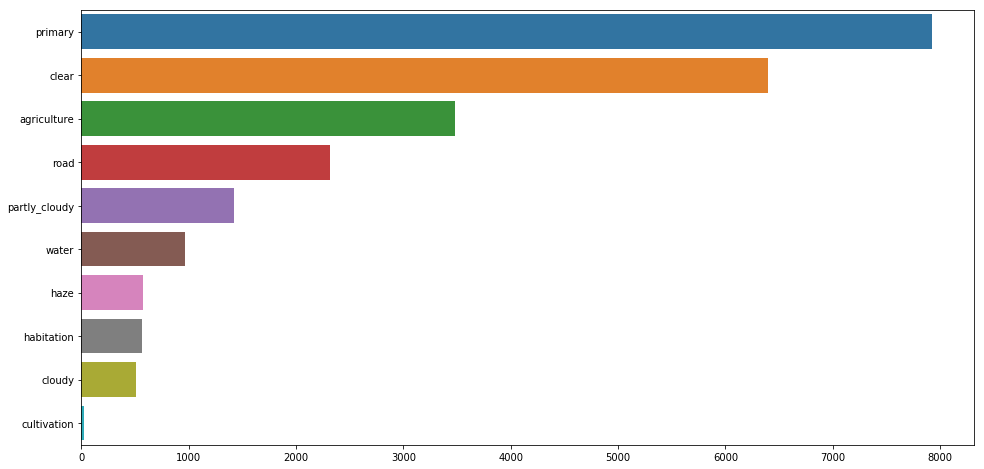

In [9]:
pred_tags = pd.Series(list(chain.from_iterable(predicted_tags))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=pred_tags, y=pred_tags.index, orient='h')

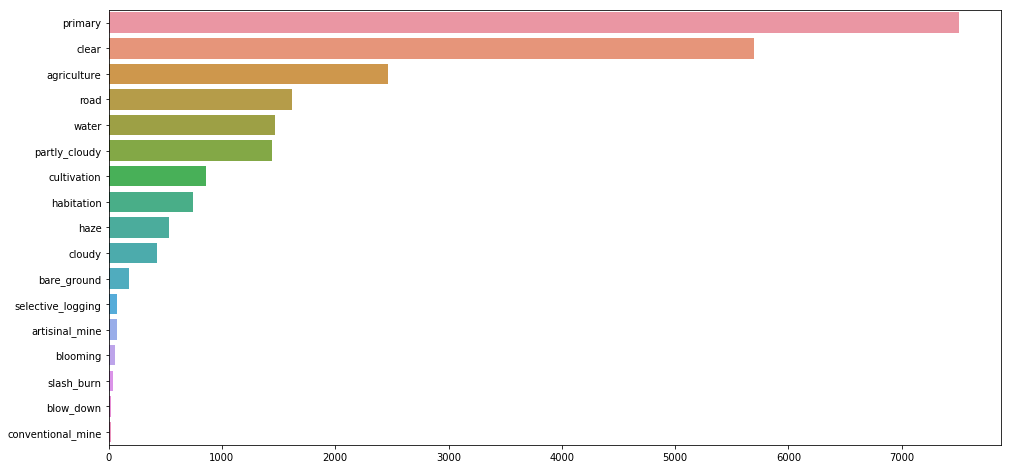

In [10]:
target_tags = pd.Series(list(chain.from_iterable(tags))).value_counts()
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=target_tags, y=target_tags.index, orient='h');

In [11]:
# cleanup
# export_trained_model(model)
shutil.rmtree('./temp')